### Company Bankruptcy V2

In [10]:
#Packages
import pandas as pd
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from tabulate import tabulate
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [1]:
#Attempting to add random minibatches in this iteration.

#Neural Net Code:
#Helper functions for nn.
#NN-from-scratch functions;
#Helper Functions
def sigmoid(Z):
    """
    Returns the sigmoid of Z, broadcast.
    Requires numpy.
    Returns Z as a cache for backprop.
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    """
    Returns the relu of Z, broadcast.
    Requires numpy.
    Returns Z as a cache for backprop.
    """
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    """
    Returns the derivative of relu.
    Requires numpy.
    Requires cache from forward relu step.
    """
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, set dz to 0 as well. 
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):
    """
    Returns the derivative of sigmoid.
    Requires numpy.
    Requires cache from forward sigmoid step.
    """
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ    

def initialize_parameters_deep(layers_dims,init):
    """
    Initializes the necessary weights and biases given the network shape.
    Current options are zeros - all zeros.  random - Ws between 0,0.1 and bs zeros. he - He. custom - pass a previously trained network.
    """
    initialization = init
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1,L):
        if initialization=='zeros':
            parameters['W' + str(l)] = np.zeros((layers_dims[l],layers_dims[l-1]))
            parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        elif initialization=='random':
            parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*0.1
            parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        elif initialization=='he':
            parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(2./layers_dims[l-1])
            parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        elif initialization[0]=='custom':
            parameters=initialization[1]
        else:
            print('init method does not match known methods')
            return
    return parameters
            

def linear_forward(A, W, b):
    """
    Simple dot product for forward pass.
    """
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Brings back the A given your activation function.
    Currently the activation in all layers is the same.
    Until the final layer, then it is sigmoid for binary classification.
    """
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    """
    Implements forward activation via RELU until the final layer - then sigmoid.
    Bring back the caches required for backprop.
    """
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))      
    return AL, caches

def compute_cost(AL, Y):
    """
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    Returns:
    cost -- currently cross-entropy cost is the only option.
    """
    m = Y.shape[1]
    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

def linear_backward(dZ, cache):
    """
    Backprop of the dot product between W and b.
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Same format as linear_forward.  Dependent on activation function.
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    """
    L = len(parameters) // 2 # number of layers in the neural networks
    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters['W'+str(l+1)]-(learning_rate*grads['dW'+str(l+1)])
        parameters["b" + str(l+1)] = parameters['b'+str(l+1)]-(learning_rate*grads['db'+str(l+1)])
        
    return parameters

def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    """
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters['W'+str(l+1)].shape[0],parameters['W'+str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters['b'+str(l+1)].shape[0],parameters['b'+str(l+1)].shape[1]))
        
    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    """
    L = len(parameters) // 2 # number of layers in the neural networks
    # Momentum update for each parameter
    for l in range(L):
        # compute velocities
        v["dW" + str(l+1)] = (beta*v['dW'+str(l+1)])+((1-beta)*grads['dW'+str(l+1)])
        v["db" + str(l+1)] = (beta*v['db'+str(l+1)])+((1-beta)*grads['db'+str(l+1)])
        # update parameters
        parameters["W" + str(l+1)] = parameters['W'+str(l+1)]-(learning_rate*v['dW'+str(l+1)])
        parameters["b" + str(l+1)] = parameters['b'+str(l+1)]-(learning_rate*v['db'+str(l+1)])
        
    return parameters, v

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    """
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters['W'+str(l+1)].shape[0],parameters['W'+str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters['b'+str(l+1)].shape[0],parameters['b'+str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters['W'+str(l+1)].shape[0],parameters['W'+str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters['b'+str(l+1)].shape[0],parameters['b'+str(l+1)].shape[1]))
    
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    """
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = (beta1*v['dW'+str(l+1)])+((1-beta1)*grads['dW'+str(l+1)])
        v["db" + str(l+1)] = (beta1*v['db'+str(l+1)])+((1-beta1)*grads['db'+str(l+1)])

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-(beta1**t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-(beta1**t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = (beta2*s['dW'+str(l+1)])+((1-beta2)*(grads['dW'+str(l+1)]**2))
        s["db" + str(l+1)] = (beta2*s['db'+str(l+1)])+((1-beta2)*(grads['db'+str(l+1)]**2))

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-(beta2**t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-(beta2**t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-(learning_rate*(v_corrected['dW'+str(l+1)]/np.sqrt(s_corrected['dW'+str(l+1)]+epsilon)))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-(learning_rate*(v_corrected['db'+str(l+1)]/np.sqrt(s_corrected['db'+str(l+1)]+epsilon)))

    return parameters, v, s




def update_parameters(parameters, grads, learning_rate,kind='gd',extras=[]):
    """
    GD, momentum, or ADAM.
    If momentum then extras is expected to be [v,beta]
    If ADAM then extras is expected to be [v,s,t,beta1,beta2,epsilon]
    """
    if kind=='gd':
        parameters_upd = update_parameters_with_gd(parameters, grads, learning_rate)
        return parameters_upd
    if kind=='momentum':
        parameters_upd,v = update_parameters_with_momentum(parameters, grads, extras[0], extras[1], learning_rate)
        return parameters_upd,v
    if kind=='adam':
        parameters_upd,v,s = update_parameters_with_adam(parameters, grads, extras[0], extras[1], extras[2], learning_rate,
                                extras[3], extras[4],  extras[5])
        return parameters_upd,v,s

def predict(X, y, parameters,threshold=0.5):
    """
    Takes X and y to give you instant feedback on accuracy.
    Classification threshold can be adjusted- but more training is recommended instead.
    """
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > threshold:
            p[0,i] = 1
        else:
            p[0,i] = 0
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    return p
    
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    np.random.seed(seed)
    m = X.shape[1]      # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
 
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False,dynamic_lr=False,init='random',opt=['gd']):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    dynamic_lr -- if True, learning rate decays every 20%
    init -- 'zeros','random',or'he'
    opt -- expected to be an array : ['gd'],['momentum',beta], or ['adam',t,beta1,beta2,epsilon]
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims,init)
    
    #Initialize the optimizer
    if opt[0] == "gd":
        pass # no initialization required for gradient descent
    elif opt[0] == "momentum":
        v = initialize_velocity(parameters)
        beta = opt[1]
    elif opt[0] == "adam":
        v, s = initialize_adam(parameters)
        t = opt[1]
        beta1 = opt[2]
        beta2 = opt[3]
        epsilon = opt[4]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        #Dynamic Learning Rate:
        if dynamic_lr ==True:
            if float(num_iterations)*0.2==i:
                learning_rate=learning_rate*0.7
                print("LR reduced 1x")
            if float(num_iterations)*0.4==i:
                learning_rate=learning_rate*0.8
                print("LR reduced 2x")
            if float(num_iterations)*0.6==i:
                learning_rate=learning_rate*0.9
                print("LR reduced 3x")
            if float(num_iterations)*0.8==i:
                learning_rate=learning_rate*0.95
                print("LR reduced 4x")

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        if opt[0] == "gd":
            parameters = update_parameters(parameters, grads, learning_rate,'gd')
        elif opt[0] == "momentum":
            parameters,v = update_parameters(parameters, grads, learning_rate,'momentum',[v,beta])
        elif opt[0] == "adam":
            t = t+1
            parameters,v,s = update_parameters(parameters, grads, learning_rate,'adam',[v,s,t,beta1,beta2,epsilon])
        
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters



In [3]:
#working dir
os.chdir('C:\\Users\\alexm\\Desktop\\Kaggle')
#import data
raw_ds = pd.read_csv('data.csv')

In [4]:
#Train/val/test split.
#split into X and y
y = raw_ds[['Bankrupt?']]
X = raw_ds.drop(columns=['Bankrupt?'])

#If we want train/validation/test, we need 2 calls to train_test_split
#This one splits into 80% train & 20% test.
Xtr, Xte, ytr, yte=train_test_split(X, y, test_size=0.2, random_state=312)
#This one splits into 80*75% train (60%) & 80*25% (20%) validation
Xtr, Xva, ytr, yva=train_test_split(Xtr, ytr, test_size=0.25, random_state=312)

In [5]:
scaler = preprocessing.StandardScaler().fit(X)
tXtr = scaler.transform(Xtr)
tXva = scaler.transform(Xva)
tXte = scaler.transform(Xte)

In [6]:
def perf_table(yhat,y,title="Model Performance"):
    f1 = f1_score(y,yhat)
    prec = precision_score(y,yhat)
    acc = accuracy_score(y,yhat)
    rec = recall_score(y,yhat)
    auc = roc_auc_score(y,yhat)

    model_stats = [title,acc,auc,prec,rec,f1]
    table_headers = ['Model','Accuracy','AUC','Precision','Recall','F1 Score']

    print(tabulate([model_stats], headers=table_headers, tablefmt='orgtbl'))
    return

In [7]:
nnXtr = np.array(tXtr.T)
nnytr = np.array(ytr.T)

nnXva = np.array(tXva.T)
nnyva = np.array(yva.T)

nnXte = np.array(tXte.T)
nnyte = np.array(yte.T)

print(nnXtr.shape)
print(nnytr.shape)

print(nnXva.shape)
print(nnyva.shape)

print(nnXte.shape)
print(nnyte.shape)

(95, 4091)
(1, 4091)
(95, 1364)
(1, 1364)
(95, 1364)
(1, 1364)


In [11]:
#Let's try some minibatches.
minis = random_mini_batches(nnXtr,nnytr, mini_batch_size = 64, seed = 0)


In [22]:
(miniX,miniY)=minis[0]

In [23]:
miniX.shape

(95, 64)

In [24]:
miniY.shape

(1, 64)

In [25]:
layers = [95,50,10,1]

Cost after iteration 0: 0.705610
Cost after iteration 100: 0.444231
Cost after iteration 200: 0.286892
Cost after iteration 300: 0.205872
Cost after iteration 400: 0.165534
Cost after iteration 500: 0.141460
Cost after iteration 600: 0.124420
Cost after iteration 700: 0.111395
Cost after iteration 800: 0.100398
Cost after iteration 900: 0.090876


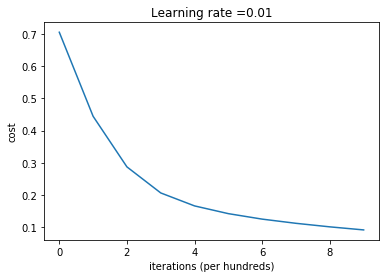

In [26]:
params =  L_layer_model(miniX,miniY,layers,learning_rate = 0.01,num_iterations=1000,print_cost=True,dynamic_lr=False,init='random',opt=['gd'])

In [28]:
#This will just keep fitting the model on the same minibatch - not what we want.  We need a new function specifically for minibatch learning

In [48]:
def mini_model(X,Y,layers_dims,batchsize,learning_rate=0.01,epochs=1,print_cost=False,dynamic_lr=False,init='random',opt=['gd'],sd=0):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID, includes minibatch learning.
    
    Arguments:
    epochs -- number of times thru the data
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    dynamic_lr -- if True, learning rate decays every 20%
    init -- 'zeros','random',or'he'
    opt -- expected to be an array : ['gd'],['momentum',beta], or ['adam',t,beta1,beta2,epsilon]
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(sd)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims,init)
    
    #Initialize the optimizer
    if opt[0] == "gd":
        pass # no initialization required for gradient descent
    elif opt[0] == "momentum":
        v = initialize_velocity(parameters)
        beta = opt[1]
    elif opt[0] == "adam":
        v, s = initialize_adam(parameters)
        t = opt[1]
        beta1 = opt[2]
        beta2 = opt[3]
        epsilon = opt[4]
    
    # Optimization loop
    for i in range(epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        sd = sd + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size=batchsize,seed=sd)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (miniX, miniY) = minibatch

            # Forward propagation
        
            #Dynamic Learning Rate:
            if dynamic_lr ==True:
                if float(epochs)*0.2==float(i):
                    learning_rate=learning_rate*0.7
                    print("LR reduced 1x")
                if float(epochs)*0.4==float(i):
                    learning_rate=learning_rate*0.8
                    print("LR reduced 2x")
                if float(epochs)*0.6==float(i):
                    learning_rate=learning_rate*0.9
                    print("LR reduced 3x")
                if float(epochs)*0.8==float(i):
                    learning_rate=learning_rate*0.95
                    print("LR reduced 4x")

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = L_model_forward(miniX, parameters)
        
            # Compute cost.
            cost = compute_cost(AL, miniY)
    
            # Backward propagation.
            grads = L_model_backward(AL, miniY, caches)
 
            # Update parameters.
            if opt[0] == "gd":
                parameters = update_parameters(parameters, grads, learning_rate,'gd')
            elif opt[0] == "momentum":
                parameters,v = update_parameters(parameters, grads, learning_rate,'momentum',[v,beta])
            elif opt[0] == "adam":
                t = t+1
                parameters,v,s = update_parameters(parameters, grads, learning_rate,'adam',[v,s,t,beta1,beta2,epsilon])
        
                
            # Print the cost 10 times.
        if print_cost and i%(epochs/10)==0:
            print ("Cost after epoch %i: %f" %(i, cost))
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after epoch 0: 0.561443
Cost after epoch 10: 0.059860
Cost after epoch 20: 0.044845
Cost after epoch 30: 0.117504
Cost after epoch 40: 0.086675
Cost after epoch 50: 0.087570
Cost after epoch 60: 0.028950
Cost after epoch 70: 0.099565
Cost after epoch 80: 0.082590
Cost after epoch 90: 0.014750


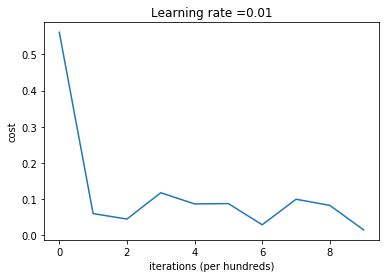

In [49]:
params_min1 = mini_model(nnXtr,nnytr,layers,batchsize=64,learning_rate=0.01,epochs=100,print_cost=True,dynamic_lr=False,init='random',opt=['gd'],sd=0)

Cost after epoch 0: 0.486805
Cost after epoch 10: 0.034595
Cost after epoch 20: 0.040369
Cost after epoch 30: 0.088193
Cost after epoch 40: 0.056512
Cost after epoch 50: 0.059543
Cost after epoch 60: 0.040007
Cost after epoch 70: 0.074918
Cost after epoch 80: 0.070442
Cost after epoch 90: 0.012580


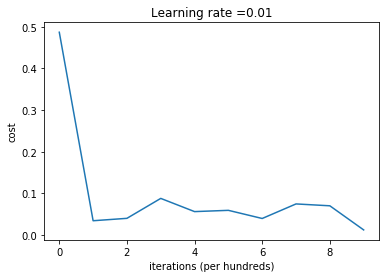

In [51]:
#Works! Let's see if it can learn well, though.

#Checking momentum to make sure it works.
layers = [95,50,25,15,10,5,1]
opti = ['momentum',0.9]
params_min2 = mini_model(nnXtr,nnytr,layers,batchsize=64,learning_rate=0.01,epochs=100,print_cost=True,dynamic_lr=False,init='he',opt=opti,sd=0)

Cost after epoch 0: 0.755821
Cost after epoch 10: 0.102330
Cost after epoch 20: 0.049409
Cost after epoch 30: 0.104918
Cost after epoch 40: 0.063148
Cost after epoch 50: 0.068931
Cost after epoch 60: 0.028459
Cost after epoch 70: 0.081496
Cost after epoch 80: 0.069925
Cost after epoch 90: 0.013873


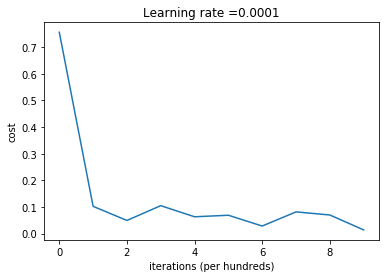

In [55]:
#Checking ADAM to make sure it works.
layers = [95,50,25,15,10,5,1]
opti = ['adam',0,0.9,0.999,1e-8]
params_min2 = mini_model(nnXtr,nnytr,layers,batchsize=64,learning_rate=0.0001,epochs=100,print_cost=True,dynamic_lr=False,init='he',opt=opti,sd=0)

In [57]:
#ADAM in-sample performance:
predictions_test = predict(nnXtr, nnytr, params_min2)
ypreds=predictions_test.T
print(ypreds.shape)
print(Xtr.shape)
perf_table(ypreds,ytr,"ADAM - IS")

Accuracy: 0.9799560009777564
(4091, 1)
(4091, 95)
| Model     |   Accuracy |      AUC |   Precision |   Recall |   F1 Score |
|-----------+------------+----------+-------------+----------+------------|
| ADAM - IS |   0.979956 | 0.744318 |      0.8125 | 0.492424 |   0.613208 |


Cost after epoch 0: 0.089191
Cost after epoch 10: 0.010092
Cost after epoch 20: 0.029777
Cost after epoch 30: 0.071989
Cost after epoch 40: 0.037114
Cost after epoch 50: 0.030547
Cost after epoch 60: 0.024103
Cost after epoch 70: 0.067144
Cost after epoch 80: 0.053488
Cost after epoch 90: 0.012314


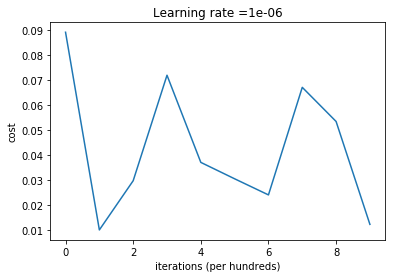

In [58]:
#Not bad - maybe we can tune it up a little bit
layers = [95,50,25,15,10,5,1]
opti = ['adam',0,0.9,0.999,1e-8]
initi = ['custom',params_min2]
params_min3 = mini_model(nnXtr,nnytr,layers,batchsize=64,learning_rate=1e-6,epochs=100,print_cost=True,dynamic_lr=False,init=initi,opt=opti,sd=0)

In [59]:
predictions_test = predict(nnXtr, nnytr, params_min3)
ypreds=predictions_test.T
print(ypreds.shape)
print(Xtr.shape)
perf_table(ypreds,ytr,"ADAM - IS")

Accuracy: 0.9802004399902229
(4091, 1)
(4091, 95)
| Model     |   Accuracy |      AUC |   Precision |   Recall |   F1 Score |
|-----------+------------+----------+-------------+----------+------------|
| ADAM - IS |     0.9802 | 0.748106 |    0.814815 |      0.5 |   0.619718 |


In [60]:
#Let's check base performance on the validation set.
predictions_test = predict(nnXva, nnyva, params_min3)
ypreds=predictions_test.T
print(ypreds.shape)
print(Xva.shape)
perf_table(ypreds,yva,"ADAM - VA")

Accuracy: 0.9684750733137832
(1364, 1)
(1364, 95)
| Model     |   Accuracy |      AUC |   Precision |   Recall |   F1 Score |
|-----------+------------+----------+-------------+----------+------------|
| ADAM - VA |   0.968475 | 0.644393 |    0.681818 | 0.294118 |   0.410959 |


In [ ]:
#Not terrible but the model is a bit overfit.  We will attempt regularization in V3.

#Let's try to tune the classification threshold on VA and see what happens with TE.
best_c = None
best_f = 0

for i in range(100):
    c = float(i)/100
    predictions_test = predict(nnXva, nnyva, params_min3,threshold=c)
    ypreds=predictions_test.T
    f = f1_score(yva,ypreds)
    
    if f>best_f:
        best_f=f
        best_c=c

In [62]:
print("best threshold:",best_c)
print("best f:",best_f)

best threshold: 0.38
best f: 0.46341463414634143


In [63]:
#Checking c=0.38 on the validation set.
predictions_test = predict(nnXva, nnyva, params_min3,threshold=0.38)
ypreds=predictions_test.T
print(ypreds.shape)
print(Xva.shape)
perf_table(ypreds,yva,"ADAM - VA")

Accuracy: 0.9677419354838712
(1364, 1)
(1364, 95)
| Model     |   Accuracy |      AUC |   Precision |   Recall |   F1 Score |
|-----------+------------+----------+-------------+----------+------------|
| ADAM - VA |   0.967742 | 0.681705 |    0.612903 | 0.372549 |   0.463415 |


In [64]:
#Still not great, need to add regularization and train longer?  Maybe larger batch size as well.
#Anyway, here is the testing performance:
predictions_test = predict(nnXte, nnyte, params_min3,threshold=0.38)
ypreds=predictions_test.T
print(ypreds.shape)
print(Xte.shape)
perf_table(ypreds,yte,"ADAM - TE")

Accuracy: 0.9743401759530794
(1364, 1)
(1364, 95)
| Model     |   Accuracy |      AUC |   Precision |   Recall |   F1 Score |
|-----------+------------+----------+-------------+----------+------------|
| ADAM - TE |    0.97434 | 0.658394 |    0.545455 | 0.324324 |    0.40678 |


In [ ]:
#The final results aren't great but in this iteration we accomplished:
# BATCH learning.  In V3 I will attempt regularization, and maybe we'll see better performance.